# Genrate Demo

In [1]:
import legacy
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = torch.device('cuda')
device

device(type='cuda')

In [3]:
# 兼容 tf 模型导出的权重文件（实际上该模已经是 Pytorch 版本的了，可以直接 pickle.load()）
models = legacy.load_network_pkl(open('./pretrained_model/ffhq.pkl', 'rb'))
models.keys()

dict_keys(['G', 'D', 'G_ema', 'training_set_kwargs', 'augment_pipe'])

In [4]:
G = models['G_ema'].to(device)
count = 0
for p in G.parameters():
    count += p.numel()
print(f"G has {count} params")

G has 30370060 params


In [5]:
label = torch.zeros([1, G.c_dim], device=device)
label

tensor([], device='cuda:0', size=(1, 0))

latent code: torch.Size([1, 512]) torch.float64
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


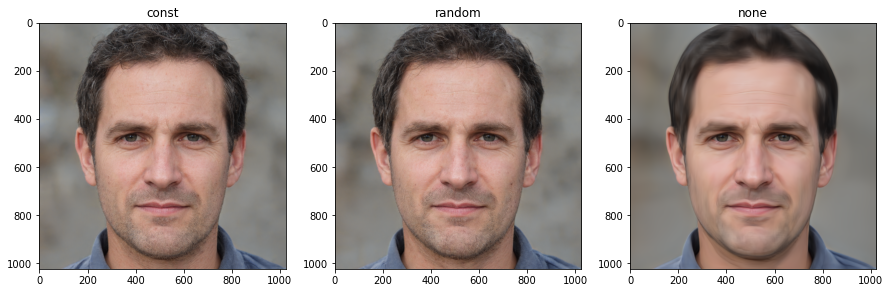

In [6]:
noise_modes = ['const', 'random', 'none']
seed = 1
truncation_psi = 0.4
z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
print("latent code:", z.shape, z.dtype)

fig = plt.figure(figsize=(15,15))
for i, noise_mode in enumerate(noise_modes):
    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clip(0, 255).to(torch.uint8)
    img = Image.fromarray(img[0].cpu().numpy(), 'RGB')
    plt.subplot(1, len(noise_modes), i+1)
    plt.imshow(img)
    plt.title(noise_mode)

# Project Latent code

In [261]:
import legacy
import dnnlib
import pickle
import torch
import PIL
import matplotlib.pyplot as plt

seed = 303
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cuda')

In [252]:
network_pkl='./pretrained_model/ffhq.pkl'
with dnnlib.util.open_url(network_pkl) as fp:
    data = legacy._LegacyUnpickler(fp).load()

In [253]:
with dnnlib.util.open_url(network_pkl) as fp:
    data = pickle.load(fp)

In [254]:
G = data['G_ema'].requires_grad_(False).to(device)

Text(0.5, 1.0, 'raw target img')

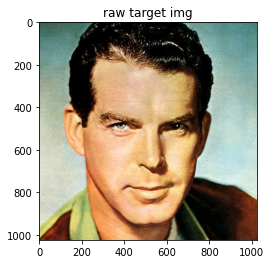

In [268]:
target_fname = './000080.jpg'
target_pil = PIL.Image.open(target_fname).convert('RGB')
plt.imshow(target_pil)
plt.title("raw target img")

w: 1024, h: 1024


Text(0.5, 1.0, '[Croped+Resized] target img')

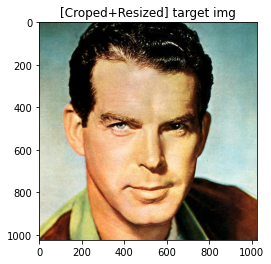

In [406]:
w, h = target_pil.size
s = min(w, h)
print(f"w: {w}, h: {h}")

# crop
target_pil = target_pil.crop(((w-s)//2, (h-s)//2, (w+s)//2, (h+s)//2))
# resize
target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.Resampling.LANCZOS)

plt.imshow(target_pil)
plt.title("[Croped+Resized] target img")

In [405]:
target_uint8 = np.asarray(target_pil, dtype=np.uint8)
target_uint8.shape

(1024, 1024, 3)

In [411]:
import copy
import torch.nn.functional as F
def project(G: torch.nn.Module, 
            target: torch.Tensor,
            *,
            num_steps=1000, 
            w_avg_samples=10000,
            initial_learning_rate = 0.1,
            initial_noise_factor=0.05,
            lr_rampdown_length=0.25,
            lr_rampup_length=0.05,
            noise_ramp_length=0.75,
            regularize_noise_weight=1e5,
            verbose=False,
            device: torch.device):
    def logprint(*args):
        if verbose:
            print(*args)
    G = copy.deepcopy(G).eval().requires_grad_(False).to(deivce)
    logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)  # [N, 512]
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)    # [N, L, C]
    print("w_samples shape:", w_samples.shape)
    w_samples = w_samples[:,:1,:].cpu().numpy().astype(np.float32)         # [N, 1, C]
    w_avg = np.mean(w_samples, axis=0, keepdims=True) # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5
    
    # steup noise inputs.
    noise_bufs = {name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }
    
    # load VGG16 feature detector
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)
        
    # Features for target image
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)
    
    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # [1, 1, C]
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device) # [num_steps, 1, C]
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)
    
    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True
        
    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0-t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for para_group in optimizer.param_groups:
            param_groups['lr'] = lr
            
        # Synthesis images from opt_w
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        synth_images = G.synthesis(ws, noise_mode='const')
        
        # Downsample image to 256*256 if it's larger than that. VGG was built for 224*224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synthesis = F.interpolate(synth_images, size=(256, 256), mode='area')
            
        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()
        
        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None, None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise * torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise * torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight
        
        # step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')
        
        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]
        
        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()
    return w_out.repeat([1, G.mapping.num_ws, 1])

In [412]:
import time
start_time = time.perf_counter()

projected_w_steps = project(G, 
                            target=torch.tensor(target_uint8),
                            num_steps=1000,
                            device=device,
                            verbose=True
                           )

Computing W midpoint and stddev using 10000 samples...
w_samples shape: torch.Size([10000, 18, 512])


Error: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__.py", line 27, in forward
      pass
    else:
      ops.prim.RaiseException("AssertionError: ")
      ~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    if resize_images:
      _4 = True

Traceback of TorchScript, original code (most recent call last):
  File "c:\p4research\research\tkarras\dnn\gan3support\feature_detectors\vgg.py", line 72, in forward
    def forward(self, img, resize_images: bool = True, return_features: bool = False, return_lpips: bool = False, use_fp16: bool = False):
        batch_size, channels, height, width = img.shape # [NCHW]
        assert channels == 3
        ~~~~~~~~~~~~~~~~~~~~ <--- HERE
        assert resize_images or return_lpips
        assert not (return_features and return_lpips)
RuntimeError: AssertionError: 


In [395]:
a  = torch.tensor([1,2,3])
a.repeat((1,2,1))

tensor([[[1, 2, 3],
         [1, 2, 3]]])